### Case Study - We are going to analyse and predict the data of the hourly vehicle counts of particular highway in the year of 1995 beginning from the month of August.

#### Import the necessary libraries.

In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

### 1. Read the data as an hourly Time Series from the '.csv' file and plot the Time Series data.

In [329]:
df = pd.read_csv('Vehicle.csv')
df.tail(10)

,Hour,Vehicles
1679,1680,785
1680,1681,465
1681,1682,249
1682,1683,178
1683,1684,181
1684,1685,194
1685,1686,373
1686,1687,1218
1687,1688,4076
1688,1689,5137


In [330]:
len(df)

1689

In [331]:
df['Time_Stamp'] = pd.date_range(start='1995-08-01', freq='H', periods=1689)

In [332]:
df

,Hour,Vehicles,Time_Stamp
0,1,699,1995-08-01 00:00:00
1,2,346,1995-08-01 01:00:00
2,3,193,1995-08-01 02:00:00
3,4,191,1995-08-01 03:00:00
4,5,193,1995-08-01 04:00:00
...,...,...,...
1684,1685,194,1995-10-10 04:00:00
1685,1686,373,1995-10-10 05:00:00
1686,1687,1218,1995-10-10 06:00:00
1687,1688,4076,1995-10-10 07:00:00


In [333]:
df = df[['Time_Stamp','Vehicles']].set_index('Time_Stamp')
df.head()

,Vehicles
Time_Stamp,
1995-08-01 00:00:00,699
1995-08-01 01:00:00,346
1995-08-01 02:00:00,193
1995-08-01 03:00:00,191
1995-08-01 04:00:00,193


### 2. Check the basic measures of descriptive statistics of the Time Series. Also, check how many days of data do we have and plot the Time Series with the mean and median of the Time Series.

In [334]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Vehicles,1689.0,2060.417999,1339.545842,154.0,851.0,2262.0,2924.0,5549.0


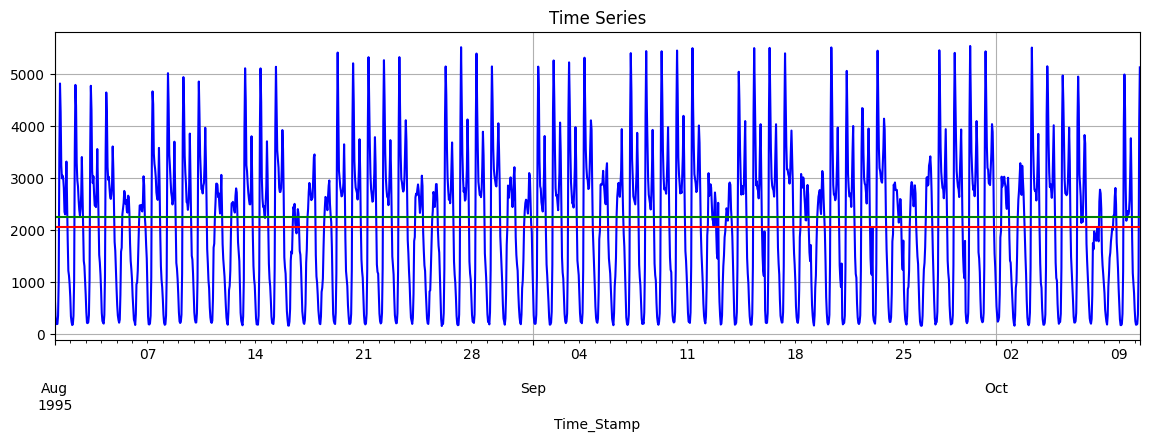

In [335]:
plt.figure(figsize=(14,4))
df['Vehicles'].plot(color='blue')
plt.axhline(df['Vehicles'].mean(), color='red')
plt.axhline(df['Vehicles'].median(), color='green')
plt.title('Time Series')
plt.grid()
plt.show()

### 3. Decompose the Time Series to understand the various components.

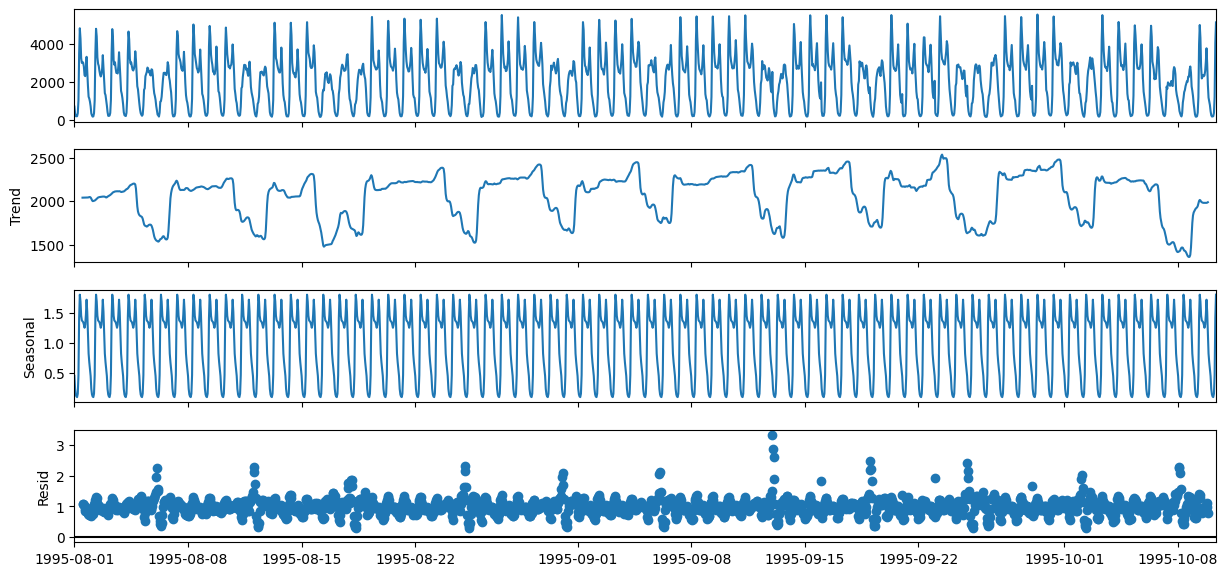

In [336]:
# Multiplicative Decomposition
a = seasonal_decompose(df, model='multiplicative')
fig = a.plot()
fig.set_size_inches((14,6))
plt.show()

### 4. Split the data into train and test and plot the training and test data.

In [337]:
y_train = df.iloc[0:int(0.7*len(df))]
y_test = df.iloc[int(0.7*len(df)):]

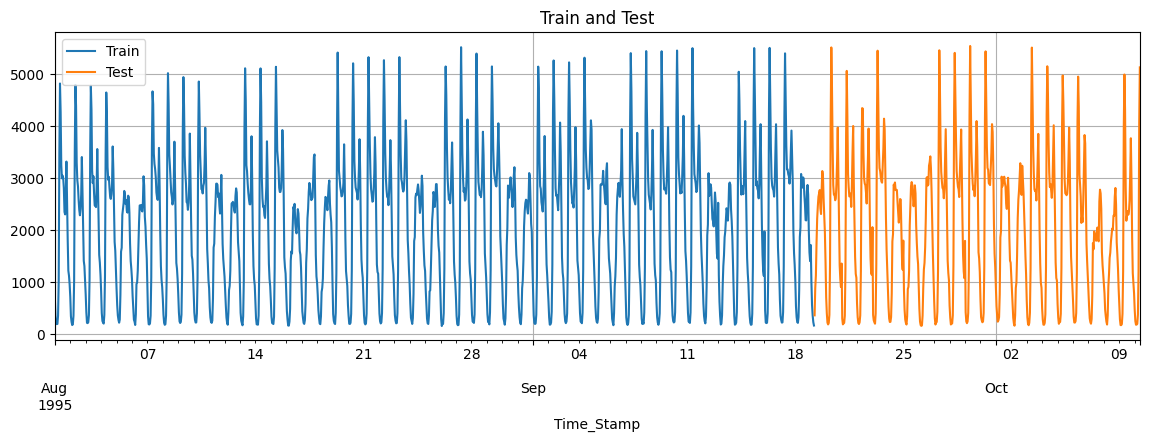

In [338]:
plt.figure(figsize=(14,4))
y_train['Vehicles'].plot()
y_test['Vehicles'].plot()

plt.title('Train and Test')
plt.legend(['Train','Test'], loc='best')
plt.grid()
plt.show()

### Model 1: Build a Linear Regression using the Time Stamped order of occurence of the vehicle count.

In [339]:
X_train = [i+1 for i in range(len(y_train))]
X_test = [i+1 for i in range(len(y_train), len(df))]

In [340]:
X_train[-1]

1182

In [341]:
len(df)

1689

In [342]:
X_test[-1]

1689

In [343]:
X_train = pd.DataFrame({'X': X_train})
X_test = pd.DataFrame({'X': X_test})

In [344]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [345]:
y_pred = model.predict(X_test)
y_test['Predictions'] = y_pred

In [346]:
y_test

,Vehicles,Predictions
Time_Stamp,,
1995-09-19 06:00:00,359,2172.681676
1995-09-19 07:00:00,886,2172.866245
1995-09-19 08:00:00,1125,2173.050813
1995-09-19 09:00:00,1753,2173.235382
1995-09-19 10:00:00,2224,2173.419951
...,...,...
1995-10-10 04:00:00,194,2265.335149
1995-10-10 05:00:00,373,2265.519718
1995-10-10 06:00:00,1218,2265.704287


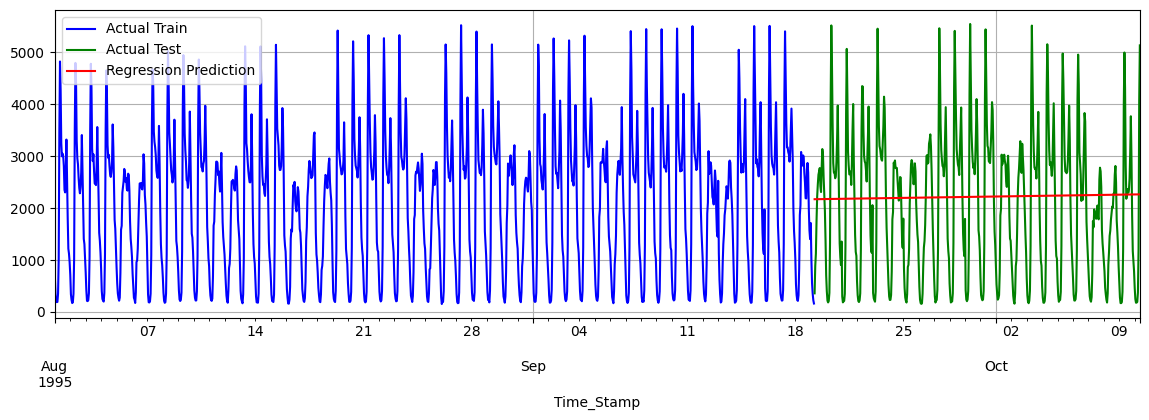

In [347]:
plt.figure(figsize=(14,4))
y_train['Vehicles'].plot(color='blue')
y_test['Vehicles'].plot(color='green')
y_test['Predictions'].plot(color='red')

plt.legend(['Actual Train','Actual Test','Regression Prediction'])
plt.grid()
plt.show()

### Evaluate this model on the test data using Root Mean Squared Error (RMSE).

In [348]:
from sklearn import metrics
score = metrics.mean_squared_error(y_test['Vehicles'], y_pred, squared=False)
print('RMSE for Regression Model:',score)
a = pd.DataFrame(columns=['RMSE'])
a.loc['Linear Regression'] = round(score,2)

RMSE for Regression Model: 1362.674157715634


In [349]:
a

,RMSE
Linear Regression,1362.67


### Model 2: Build a Simple Exponential Smoothing model by using the parameter 'optimise=True' within the '.fit()' function. Then,evaluate the same model on the test set using RMSE.

In [350]:
model_SES = SimpleExpSmoothing(y_train, initialization_method='estimated')

In [351]:
model_SES_autofit = model_SES.fit(optimized=True)

In [352]:
model_SES_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': -1197.6666666666658,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [353]:
SES_predict = model_SES_autofit.forecast(len(y_test))
SES_predict

1995-09-19 06:00:00    163.318201
1995-09-19 07:00:00    163.318201
1995-09-19 08:00:00    163.318201
1995-09-19 09:00:00    163.318201
1995-09-19 10:00:00    163.318201
                          ...    
1995-10-10 04:00:00    163.318201
1995-10-10 05:00:00    163.318201
1995-10-10 06:00:00    163.318201
1995-10-10 07:00:00    163.318201
1995-10-10 08:00:00    163.318201
Freq: H, Length: 507, dtype: float64

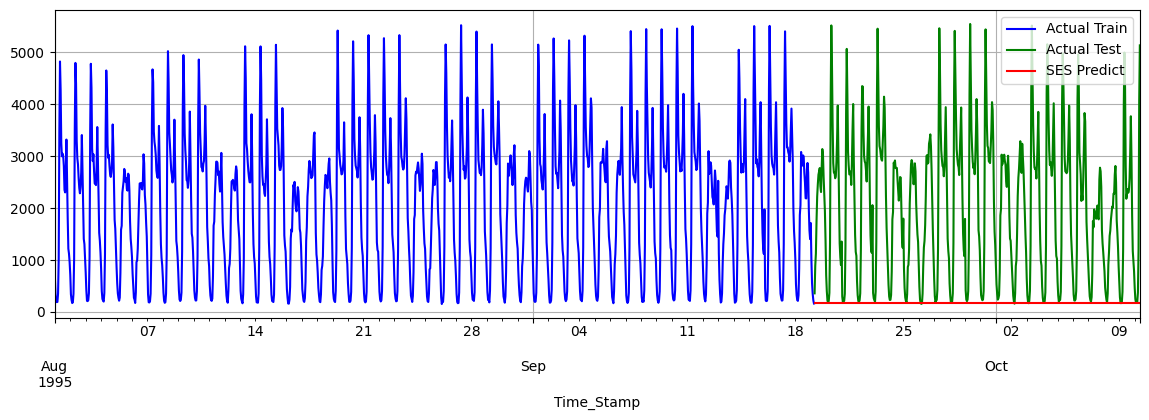

In [354]:
plt.figure(figsize=(14,4))
y_train['Vehicles'].plot(color='blue')
y_test['Vehicles'].plot(color='green')
SES_predict.plot(color='red')

plt.legend(['Actual Train','Actual Test','SES Predict'])
plt.grid()
plt.show()

In [355]:
score = metrics.mean_squared_error(y_test['Vehicles'], SES_predict, squared=False)
print('Simple Exponential Smoothing RMSE:', score)
a.loc['SES'] = round(score,2)

Simple Exponential Smoothing RMSE: 2322.773949796665


In [356]:
a

,RMSE
Linear Regression,1362.67
SES,2322.77


### Model 3: Build a Double Exponential Smoothing model by using the parameter 'optimise=True' within the '.fit()' function. Then,evaluate the same model on the test set using RMSE.

In [357]:
model_DES = Holt(y_train, initialization_method='estimated')

In [358]:
model_DES_autofit = model_DES.fit(optimized=True)

In [359]:
model_DES_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': 0.995,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': -1197.6666666666658,
 'initial_trend': 501.0121212121212,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [360]:
DES_predict = model_DES_autofit.forecast(len(y_test))
DES_predict

1995-09-19 06:00:00       99.451324
1995-09-19 07:00:00       36.222309
1995-09-19 08:00:00      -27.006706
1995-09-19 09:00:00      -90.235721
1995-09-19 10:00:00     -153.464736
                           ...     
1995-10-10 04:00:00   -31641.514216
1995-10-10 05:00:00   -31704.743231
1995-10-10 06:00:00   -31767.972246
1995-10-10 07:00:00   -31831.201261
1995-10-10 08:00:00   -31894.430276
Freq: H, Length: 507, dtype: float64

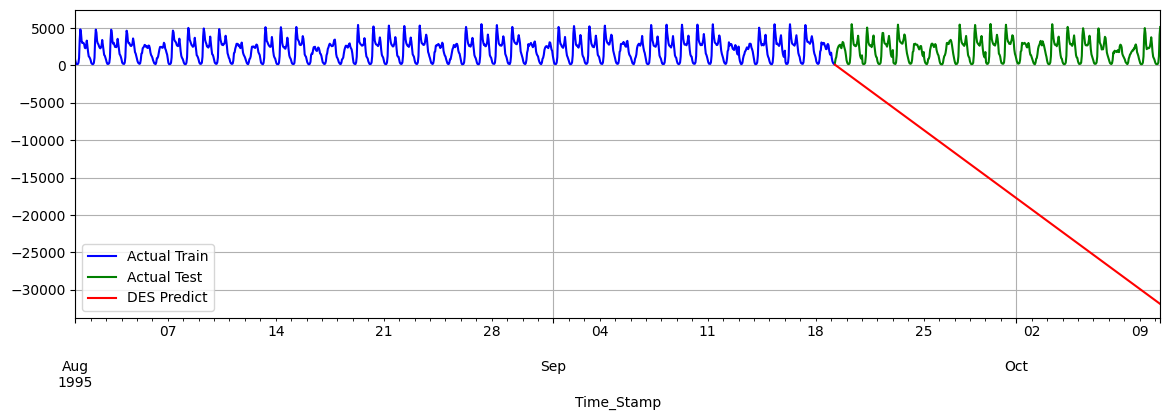

In [361]:
plt.figure(figsize=(14,4))
y_train['Vehicles'].plot(color='blue')
y_test['Vehicles'].plot(color='green')
DES_predict.plot(color='red')

plt.legend(['Actual Train','Actual Test','DES Predict'])
plt.grid()
plt.show()

In [362]:
score = metrics.mean_squared_error(y_test['Vehicles'], DES_predict, squared=False)
print('Holts Double Exponential Smoothing RMSE:', score)
a.loc['DES'] = round(score,2)

Holts Double Exponential Smoothing RMSE: 20198.794201121087


In [363]:
a

,RMSE
Linear Regression,1362.67
SES,2322.77
DES,20198.79


### Model 4: Build a Triple Exponential Smoothing model by using the parameter 'optimise=True' within the '.fit()' function. Then,evaluate the same model on the test set using RMSE.

In [364]:
model_TES_add = ExponentialSmoothing(y_train, trend='additive', seasonal='additive', initialization_method='estimated')

In [365]:
model_TES_add_autofit = model_TES_add.fit(optimized=True)

In [366]:
model_TES_add_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.0050000000000000044,
 'damping_trend': nan,
 'initial_level': 2041.3402777777765,
 'initial_trend': 0.28699494949506743,
 'initial_seasons': array([-1188.43684896, -1549.31184896, -1712.14518229, -1757.49934896,
        -1769.52018229, -1635.96289062,  -982.15039063,  1052.58398438,
         2002.91210938,  1835.18815104,  1034.22460938,   856.70377604,
          921.90690104,   709.40690104,   508.45898438,   356.18815104,
          389.39648438,   696.17773438,  1404.72460938,   778.17773438,
          104.22981771,  -525.92122396,  -640.37434896,  -888.95768229]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [367]:
TES_predict = model_TES_add_autofit.forecast(len(y_test))
TES_predict

1995-09-19 06:00:00     820.020660
1995-09-19 07:00:00    2869.617684
1995-09-19 08:00:00    3788.550068
1995-09-19 09:00:00    3598.599738
1995-09-19 10:00:00    2876.736187
                          ...     
1995-10-10 04:00:00     144.110552
1995-10-10 05:00:00     280.158588
1995-10-10 06:00:00     936.183909
1995-10-10 07:00:00    2985.780933
1995-10-10 08:00:00    3904.713317
Freq: H, Length: 507, dtype: float64

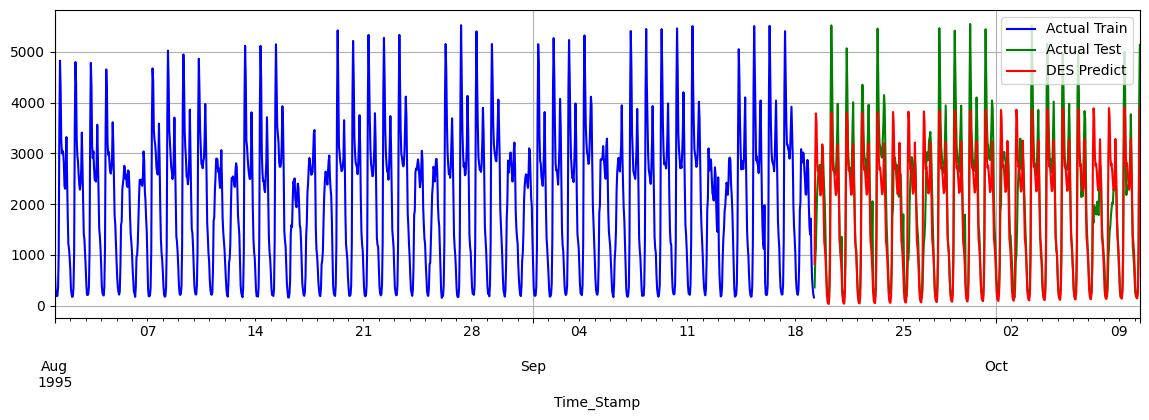

In [368]:
plt.figure(figsize=(14,4))
y_train['Vehicles'].plot(color='blue')
y_test['Vehicles'].plot(color='green')
TES_predict.plot(color='red')

plt.legend(['Actual Train','Actual Test','DES Predict'])
plt.grid()
plt.show()

In [369]:
score = metrics.mean_squared_error(y_test['Vehicles'], TES_predict, squared=False)
print('Holts Winter Exponential Smoothing RMSE:', score)
a.loc['TES'] = round(score,2)

Holts Winter Exponential Smoothing RMSE: 699.28195981447


### Which model performs the best?

In [370]:
a

,RMSE
Linear Regression,1362.67
SES,2322.77
DES,20198.79
TES,699.28


#### Clearly, Holt Winters Linear Model is way better than the rest.

---

##### Tweak the different parameters for each of these models and try to come up with a better accuracy (less RMSE)

##### Note: You can go ahead and attempt the following questions now or wait until after the mentored learning session. During the mentor learning sessions, you will get clarity on how to solve the following questions.

### Model 5: Build a Simple Exponential Smoothing model by taking the best alpha [in the range of 0.01 to 1 taking an interval of 0.01] in terms of the least RMSE. Then,evaluate the same model on the test data. Also, do make sure that 'optimized = False' within the '.fit()' command.

In [371]:
b = pd.DataFrame(columns=['Alpha','RMSE'])

In [372]:
for i in np.arange(0.01,1,0.01):
    model_SES_autofit = model_SES.fit(smoothing_level=i, optimized=False, use_brute=True)
    SES_predict = model_SES_autofit.forecast(len(y_test))
    rmse = metrics.mean_squared_error(y_test['Vehicles'], SES_predict, squared=False)
    b.loc[len(b.index)] = [i,rmse]

In [373]:
b

,Alpha,RMSE
0,0.01,1351.374730
1,0.02,1350.523209
2,0.03,1354.426401
3,0.04,1364.089357
4,0.05,1378.518123
...,...,...
94,0.95,2320.188858
95,0.96,2320.805848
96,0.97,2321.397448
97,0.98,2321.965005


In [374]:
b.sort_values('RMSE').iloc[0][1]

1350.523209376406

In [375]:
a.loc['SES,alpha=0.02'] = b.sort_values('RMSE').iloc[0][1]

In [376]:
a

,RMSE
Linear Regression,1362.670000
SES,2322.770000
DES,20198.790000
TES,699.280000
"SES,alpha=0.02",1350.523209


### Model 6: Build a Double Exponential Smoothing model by taking the best alpha and beta [both in the range of 0.01 to 1 taking an interval of 0.01] in terms of the least RMSE. Then,evaluate the same model on the test data. Also, do make sure that 'optimized = False' within the '.fit()' command.

In [377]:
b = pd.DataFrame(columns=['Alpha','Beta','RMSE'])

In [379]:
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        model_DES_autofit = model_DES.fit(smoothing_level=i, smoothing_trend=j, optimized=False, use_brute=True)
        DES_predict = model_DES_autofit.forecast(len(y_test))
        rmse = metrics.mean_squared_error(y_test['Vehicles'], DES_predict, squared=False)
        b.loc[len(b.index)] = [i,j,rmse]

In [381]:
b

,Alpha,Beta,RMSE
0,0.01,0.01,1461.745244
1,0.01,0.02,1449.237207
2,0.01,0.03,1361.505740
3,0.01,0.04,1471.236944
4,0.01,0.05,1350.068819
...,...,...,...
9529,1.00,0.60,35490.672177
9530,1.00,0.70,29777.880058
9531,1.00,0.80,25411.078314
9532,1.00,0.90,22309.983387


In [382]:
b.sort_values('RMSE').iloc[0]

Alpha       0.010000
Beta        0.050000
RMSE     1350.068819
Name: 4, dtype: float64

In [383]:
a.loc['DES,alpha=0.01,beta=0.05'] = b.sort_values('RMSE').iloc[0][2]

In [384]:
a

,RMSE
Linear Regression,1362.670000
SES,2322.770000
DES,20198.790000
TES,699.280000
"SES,alpha=0.02",1350.523209
"DES,alpha=0.01,beta=0.05",1350.068819


### Model 7: Build a Triple Exponential Smoothing model by taking the best alpha, beta and gamma [all in the range of 0.1 to 1 taking an interval of 0.1] in terms of the least RMSE. Then,evaluate the same model on the test data. Also, do make sure that 'optimized = False' within the '.fit()' command.

In [385]:
b = pd.DataFrame(columns=['Alpha','Beta','Gamma','RMSE'])

In [386]:
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        for k in np.arange(0.1,1.1,0.1):
            model_TES_add_autofit = model_TES_add.fit(smoothing_level=i, smoothing_trend=j, smoothing_seasonal=k, optimized=False, use_brute=True)
            TES_predict = model_TES_add_autofit.forecast(len(y_test))
            rmse = metrics.mean_squared_error(y_test['Vehicles'], TES_predict, squared=False)
            b.loc[len(b.index)] = [i,j,k,rmse]

In [387]:
b

,Alpha,Beta,Gamma,RMSE
0,0.1,0.1,0.1,6.357606e+03
1,0.1,0.1,0.2,7.312562e+03
2,0.1,0.1,0.3,8.332071e+03
3,0.1,0.1,0.4,9.598671e+03
4,0.1,0.1,0.5,1.102137e+04
...,...,...,...,...
995,1.0,1.0,0.6,2.003928e+13
996,1.0,1.0,0.7,3.497429e+16
997,1.0,1.0,0.8,3.419055e+19
998,1.0,1.0,0.9,4.228488e+22


In [388]:
b.sort_values('RMSE').iloc[0]

Alpha      0.800000
Beta       0.100000
Gamma      0.300000
RMSE     959.522754
Name: 702, dtype: float64

In [389]:
a.loc['TES,alpha=0.01,beta=0.05,gamma=0.27'] = b.sort_values('RMSE').iloc[0][3]

### Which model performs the best?

In [390]:
a

,RMSE
Linear Regression,1362.670000
SES,2322.770000
DES,20198.790000
TES,699.280000
"SES,alpha=0.02",1350.523209
"DES,alpha=0.01,beta=0.05",1350.068819
"TES,alpha=0.01,beta=0.05,gamma=0.27",959.522754


### Holt Winter's model with self optimization has lowest RMSE. By tweaking more into this model we can redice RMSE further.

##### Try to play around with the parameters of the models to get a better accuracy score i.e. a lower RMSE on the test data.

##### Happy Learning!

## END